In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

## Load Data

* take item 7798 as an example since it's continuous
* aggregate sales per day

In [2]:
#load data
df_train = pd.read_csv('./Data/orders0206_train.csv', sep = '|', parse_dates=['time'])
df_train_small = df_train[df_train["itemID"].isin([7798])]
display(df_train_small.head(3))

,time,transactID,itemID,order,salesPrice
226,2018-01-01 10:36:22,2256999,7798,2,10.97
731,2018-01-01 12:52:49,2263392,7798,1,10.97
2319,2018-01-01 16:39:16,2272248,7798,1,10.97


In [3]:
# aggregate sales per day
df_train_small['date'] = [d.date() for d in df_train_small['time']]
df_aggregated = df_train_small.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})
df_aggregated.head()

,itemID,date,count
0,7798,2018-01-01,17
1,7798,2018-01-02,36
2,7798,2018-01-03,24
3,7798,2018-01-04,41
4,7798,2018-01-05,32


## Make Time Series & Train Test Split

* make series continous
* make date column as index
* take last 1 week period for testing

In [4]:
# add 0 sales for missing dates per itemID
for prod in df_aggregated.itemID.unique():
    s = df_aggregated.loc[df_aggregated['itemID'] == prod][["date","count"]]
    s = s.set_index("date")
    idx = pd.date_range(s.index.min(), 
                        s.index.max())
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    if "df_timeseries" not in globals():
        s["itemID"] = prod
        df_timeseries = s
    else:
        s["itemID"] = prod
        df_timeseries = pd.concat([df_timeseries,s], ignore_index=False)
df_timeseries.head(3)

,count,itemID
2018-01-01,17,7798
2018-01-02,36,7798
2018-01-03,24,7798


In [5]:
import copy
# drop itemID as we don't need it for training
# 1 week period of testing
df_timeseries.drop(columns=['itemID'], inplace=True)
df = copy.deepcopy(df_timeseries[12:]) 
train, test = df[:-14], df[-14:]

## Feed Into LSTM

* scale our data between -1 & 1
* generate time series dataset with lags 7 (1 week) in our case
* set model - LSTM 
* train :)

In [6]:
# first we need to scale our data between -1 & 1
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [7]:
n_input = 14
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=7)
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=500, shuffle = False, verbose = 1)

Epoch 1/500
16/16 [==============================] - 4s 219ms/step - loss: 0.0520
Epoch 2/500
16/16 [==============================] - 1s 54ms/step - loss: 0.0261
Epoch 3/500
16/16 [==============================] - 1s 39ms/step - loss: 0.0279
Epoch 4/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0263
Epoch 5/500
16/16 [==============================] - 1s 38ms/step - loss: 0.0262
Epoch 6/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0266
Epoch 7/500
16/16 [==============================] - 2s 104ms/step - loss: 0.0265
Epoch 8/500
16/16 [==============================] - 1s 43ms/step - loss: 0.0261
Epoch 9/500
16/16 [==============================] - 1s 32ms/step - loss: 0.0265
Epoch 10/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0260
Epoch 11/500
16/16 [==============================] - 1s 41ms/step - loss: 0.0255
Epoch 12/500
16/16 [==============================] - 1s 39ms/step - loss: 0.0267
Epoch 13/500
16/16 [===

Epoch 101/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0239
Epoch 102/500
16/16 [==============================] - 0s 25ms/step - loss: 0.0274
Epoch 103/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0258
Epoch 104/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0259
Epoch 105/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0255
Epoch 106/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0253
Epoch 107/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0253
Epoch 108/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0252
Epoch 109/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0258
Epoch 110/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0248
Epoch 111/500
16/16 [==============================] - 0s 30ms/step - loss: 0.0252
Epoch 112/500
16/16 [==============================] - 1s 33ms/step - loss: 0.0258
Epoc

16/16 [==============================] - 0s 24ms/step - loss: 0.0224
Epoch 200/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0223
Epoch 201/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0218
Epoch 202/500
16/16 [==============================] - 0s 29ms/step - loss: 0.0224
Epoch 203/500
16/16 [==============================] - 0s 30ms/step - loss: 0.0219
Epoch 204/500
16/16 [==============================] - 0s 30ms/step - loss: 0.0211
Epoch 205/500
16/16 [==============================] - 1s 36ms/step - loss: 0.0217
Epoch 206/500
16/16 [==============================] - 0s 30ms/step - loss: 0.0218
Epoch 207/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0210
Epoch 208/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0216
Epoch 209/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0218
Epoch 210/500
16/16 [==============================] - 1s 33ms/step - loss: 0.0222
Epoch 211/500
16/1

16/16 [==============================] - 1s 43ms/step - loss: 0.0133
Epoch 298/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0143
Epoch 299/500
16/16 [==============================] - 1s 36ms/step - loss: 0.0146
Epoch 300/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0145
Epoch 301/500
16/16 [==============================] - 1s 35ms/step - loss: 0.0183
Epoch 302/500
16/16 [==============================] - 1s 36ms/step - loss: 0.0197
Epoch 303/500
16/16 [==============================] - 1s 33ms/step - loss: 0.0161
Epoch 304/500
16/16 [==============================] - 1s 31ms/step - loss: 0.0222
Epoch 305/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0170
Epoch 306/500
16/16 [==============================] - 1s 39ms/step - loss: 0.0171
Epoch 307/500
16/16 [==============================] - 0s 29ms/step - loss: 0.0144
Epoch 308/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0125
Epoch 309/500
16/1

16/16 [==============================] - 0s 26ms/step - loss: 0.0070
Epoch 396/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0086
Epoch 397/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0187
Epoch 398/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0160
Epoch 399/500
16/16 [==============================] - 0s 29ms/step - loss: 0.0134
Epoch 400/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0088
Epoch 401/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0107
Epoch 402/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0072
Epoch 403/500
16/16 [==============================] - 0s 24ms/step - loss: 0.0078
Epoch 404/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0069
Epoch 405/500
16/16 [==============================] - 0s 29ms/step - loss: 0.0063
Epoch 406/500
16/16 [==============================] - 0s 31ms/step - loss: 0.0054
Epoch 407/500
16/1

16/16 [==============================] - 0s 27ms/step - loss: 0.0042
Epoch 494/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0035
Epoch 495/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0042
Epoch 496/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0039
Epoch 497/500
16/16 [==============================] - 0s 27ms/step - loss: 0.0037
Epoch 498/500
16/16 [==============================] - 0s 28ms/step - loss: 0.0042
Epoch 499/500
16/16 [==============================] - 0s 26ms/step - loss: 0.0037
Epoch 500/500
16/16 [==============================] - 0s 30ms/step - loss: 0.0033


## Make Prediction

* create an empty list for each of our 7 predictions
* create the batch that our model will predict off of
* save the prediction to our list
* add the prediction to the end of the batch to be used in the next prediction

In [8]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [9]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, columns=['Prediction'])
df_test = pd.concat([df,df_predict], axis=1)

## Prediction Plot

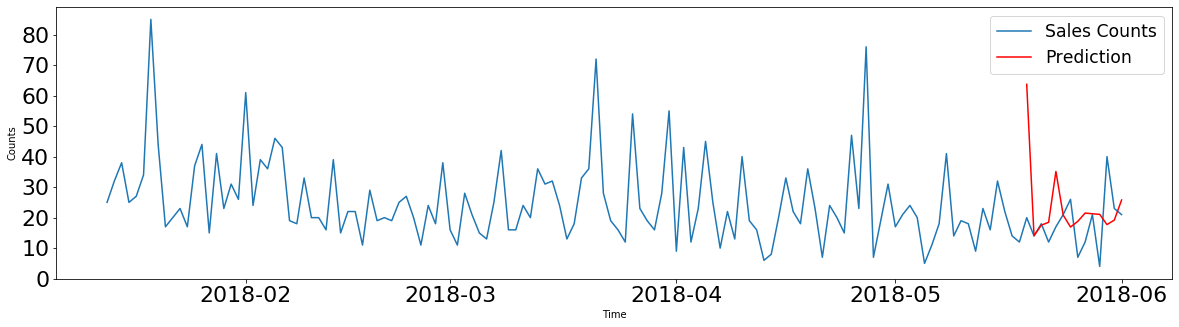

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['count'], label="Sales Counts")
plt.plot(df_test.index, df_test['Prediction'], color='r', label="Prediction")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Time")
plt.ylabel("Counts")
plt.savefig('sales_prediction.png')
plt.show()

## Predicting Beyond the Dataset

* take the whole dataset for training
* scale the data 
* set and train the model
* create prediction
* creat new dates for prediction data

In [11]:
train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 14
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=7)
model.fit_generator(generator, epochs=150, shuffle = False, verbose = 1)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/150
18/18 [==============================] - 1s 31ms/step - loss: 0.0061
Epoch 2/150
18/18 [==============================] - 1s 33ms/step - loss: 0.0102
Epoch 3/150
18/18 [==============================] - 1s 35ms/step - loss: 0.0073
Epoch 4/150
18/18 [==============================] - 1s 29ms/step - loss: 0.0064
Epoch 5/150
18/18 [==============================] - 1s 28ms/step - loss: 0.0048
Epoch 6/150
18/18 [==============================] - 1s 32ms/step - loss: 0.0055
Epoch 7/150
18/18 [==============================] - 1s 30ms/step - loss: 0.0100
Epoch 8/150
18/18 [==============================] - 1s 36ms/step - loss: 0.0049
Epoch 9/150
18/18 [==============================] - 1s 33ms/step - loss: 0.0061
Epoch 10/150
18/18 [==============================] - 1s 30ms/step - loss: 0.0043
Epoch 11/150
18/18 [==============================] - 1s 31ms/step - loss: 0.0042
Epoch 12/150
18/18 [==============================] - 1s 30ms/step - loss: 0.0037
Epoch 13/150
18/18 [=====

18/18 [==============================] - 1s 34ms/step - loss: 0.0023
Epoch 102/150
18/18 [==============================] - 1s 30ms/step - loss: 0.0022
Epoch 103/150
18/18 [==============================] - 1s 35ms/step - loss: 0.0026
Epoch 104/150
18/18 [==============================] - 1s 39ms/step - loss: 0.0023
Epoch 105/150
18/18 [==============================] - 1s 29ms/step - loss: 0.0024
Epoch 106/150
18/18 [==============================] - 0s 27ms/step - loss: 0.0022
Epoch 107/150
18/18 [==============================] - 0s 27ms/step - loss: 0.0023
Epoch 108/150
18/18 [==============================] - 1s 29ms/step - loss: 0.0033
Epoch 109/150
18/18 [==============================] - 1s 30ms/step - loss: 0.0022
Epoch 110/150
18/18 [==============================] - 1s 28ms/step - loss: 0.0020
Epoch 111/150
18/18 [==============================] - 1s 29ms/step - loss: 0.0027
Epoch 112/150
18/18 [==============================] - 0s 24ms/step - loss: 0.0025
Epoch 113/150
18/1

In [14]:
# create new dates for our prediction
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,15) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [15]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

## Prediction Plot

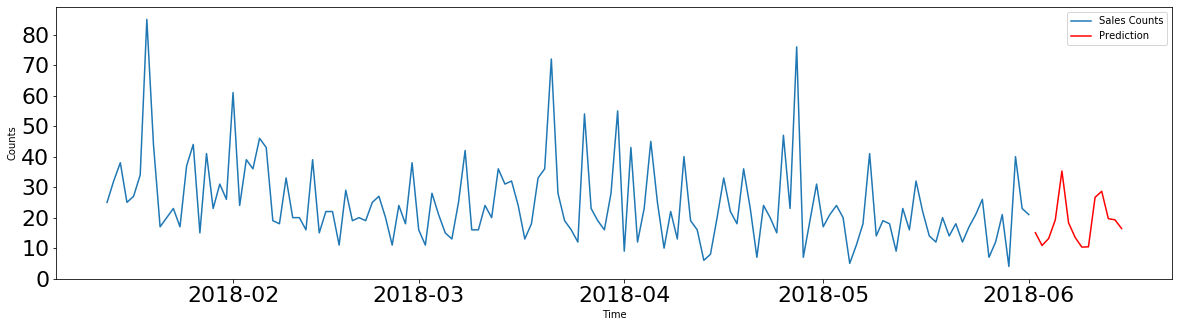

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['count'], label="Sales Counts")
plt.plot(df_proj.index, df_proj['Prediction'], label="Prediction", color='r')
plt.legend(loc='best')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Time")
plt.ylabel("Counts")
plt.savefig('sales_future_prediction.png')
plt.show()